# Machine Learning Algorithms – Assessment

- Author Name: Madhu Asmitha Parthiban Sangeetha
- Student ID: 25037384
- Course: Machine Learning Algorithms

This Jupyter notebook analyses TB symptoms dataset . It performs the following reproducible steps on the provided CSV ("TB disease symptoms(Raw).csv"):

- Data loading and column cleaning
- Null handling and duplicate removal
- Categorical encoding 
- Exploratory Data Analysis with inline plots:
  - Frequency plots per symptom
  - Correlation heatmap
  - Boxplots for engineered numeric features
  - Target distribution check
  - Mutual Information (feature importance)
- Basic feature engineering:
  - symptom_count
  - severity_scale (MI-weighted)
  - interaction features between top MI features
  - PCA
- Train-test split (stratified): test_size=0.2, random_state=42
- Baseline classification using Logistic Regression inside a pipeline
- Evaluation: accuracy, precision, recall, f1, ROC AUC, confusion matrix, ROC curve

Notes:
- Place the CSV file in the same directory as this notebook and update the path in the first code cell if needed.
- The notebook is organised so you can run cell-by-cell and inspect plots or tweak choices easily.


## Dataset Description and Source

This study uses the **Tuberculosis Symptoms dataset** obtained from Kaggle.

**Dataset source:**  
Kaggle – Tuberculosis Symptoms  
https://www.kaggle.com/datasets/victorcaelina/tuberculosis-symptoms

**Selected file used in this project:**  
**`Tb disease symptoms without id and datetime.csv`**

### Dataset Overview
The dataset contains patient-level records describing the presence or absence of key tuberculosis (TB) symptoms. Each feature is represented as a binary indicator (0 = symptom absent, 1 = symptom present). The dataset is designed for symptom-based analysis and predictive modelling of tuberculosis risk.


The **identifier and datetime fields have been excluded**, ensuring the dataset contains only clinically relevant symptom attributes suitable for machine learning analysis.

### Target Construction
No explicit diagnosis label is provided in the original dataset. Therefore, a derived target variable (`tb_diagnosis`) is constructed based on the presence of multiple clinically significant TB symptoms. This approach aligns with symptom-based screening methodologies commonly used in early TB detection.



## Environment Setup and Library Imports

This section initialises the computational environment required for data preprocessing, exploratory analysis, feature engineering, modelling, and evaluation. All necessary libraries are imported to support numerical computation, data manipulation, visualisation, and machine learning workflows.

### Libraries Used

- **NumPy & Pandas** for numerical operations and data handling  
- **Matplotlib & Seaborn** for visualisation and plotting  
- **Scikit-learn** for preprocessing, feature selection, dimensionality reduction, model training, and evaluation  
- **Joblib** for saving trained models efficiently  

Warnings are suppressed to ensure clean notebook output, and inline plotting is enabled for immediate visual feedback.

### Directory Setup

Dedicated directories are created to organise outputs generated during execution:
- **`figures/`** → stores visualisations and plots  
- **`models/`** → stores trainghout the notebook.


In [50]:
# Basic library import
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve)
import joblib

%pip install xgboost


# Plotting style
sns.set(style='whitegrid')
%matplotlib inline

# Directories for storing figures and models
FIG_DIR = 'figures'
MODEL_DIR = 'models'
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print('Necessary libraries are imported successfully. Figures will be saved to ./figures and model to ./models')

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Necessary libraries are imported successfully. Figures will be saved to ./figures and model to ./models


## 1) Load the data

The first step in this assessment is to load the dataset that will be used for analysis and optimisation.  
The dataset is provided in CSV **(Comma-Separated Values)** format and is stored in the same directory as this notebook to ensure easy access without modifying file paths.

Before performing any preprocessing or analysis, it is important to **inspect the raw data** to understand its structure and contents. This initial inspection helps identify:
- The number of features (columns) present in the dataset
- The type of data stored in each column
- Any potential issues, such as missing values and incorrect formatting

To achieve this, the dataset is loaded using the pandas library, and basic exploratory commands are applied.  
Specifically:
- The **head()** function is used to view the first few rows of the dataset
- The **columns** attribute is used to list all column names


In [51]:
# Path to CSV
csv_path = 'Rawset_Tb disease symptoms csv.csv'

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at {csv_path}. Please place the file next to this notebook or update csv_path.")

# Read as strings, then clean
df_raw = pd.read_csv(csv_path, dtype=str)
print('Raw shape:', df_raw.shape)
df_raw.head()

Raw shape: (1000, 16)


,no,name,gender,fever for two weeks,coughing blood,sputum mixed with blood,night sweats,chest pain,back pain in certain parts,shortness of breath,weight loss,body feels tired,lumps that appear around the armpits and neck,cough and phlegm continuously for two weeks to four weeks,swollen lymph nodes,loss of appetite
0,1,Carolyn,Female,0,0,0,1,0,0,0,1,1,1,1,1,0
1,2,Bari,Female,1,0,1,1,1,0,1,0,1,0,0,1,1
2,3,Edita,Male,0,0,0,1,1,1,1,0,0,0,1,0,1
3,4,Emmery,Female,0,0,1,0,1,0,0,0,0,1,0,0,0
4,5,Hilly,Female,0,0,0,1,0,0,1,0,1,0,0,1,0


### Clean column names helper
We will normalize column names to lower_with_underscores so they are easier to understand.

In [52]:
def clean_column_names(df):
    cols = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('/', '_')
        .str.replace(r'[^0-9a-z_]', '', regex=True)
    )
    df = df.copy()
    df.columns = cols
    return df

df = clean_column_names(df_raw)
print('Cleaned column names:')
df.columns.tolist()[:30]

Cleaned column names:


['no',
 'name',
 'gender',
 'fever_for_two_weeks',
 'coughing_blood',
 'sputum_mixed_with_blood',
 'night_sweats',
 'chest_pain',
 'back_pain_in_certain_parts',
 'shortness_of_breath',
 'weight_loss',
 'body_feels_tired',
 'lumps_that_appear_around_the_armpits_and_neck',
 'cough_and_phlegm_continuously_for_two_weeks_to_four_weeks',
 'swollen_lymph_nodes',
 'loss_of_appetite']

### Trimming whitespace and inspect types
Here, strings are  trimmed of whitespace. Many symptom columns are stored as 0/1 strings.

In [53]:
# Trim string cells
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

display(df.head())
print('\nColumns and sample unique values (first 40 columns):')
for c in df.columns[:40]:
    vals = df[c].dropna().unique()
    print(f"{c}: {list(vals)[:6]}")

,no,name,gender,fever_for_two_weeks,coughing_blood,sputum_mixed_with_blood,night_sweats,chest_pain,back_pain_in_certain_parts,shortness_of_breath,weight_loss,body_feels_tired,lumps_that_appear_around_the_armpits_and_neck,cough_and_phlegm_continuously_for_two_weeks_to_four_weeks,swollen_lymph_nodes,loss_of_appetite
0,1,Carolyn,Female,0,0,0,1,0,0,0,1,1,1,1,1,0
1,2,Bari,Female,1,0,1,1,1,0,1,0,1,0,0,1,1
2,3,Edita,Male,0,0,0,1,1,1,1,0,0,0,1,0,1
3,4,Emmery,Female,0,0,1,0,1,0,0,0,0,1,0,0,0
4,5,Hilly,Female,0,0,0,1,0,0,1,0,1,0,0,1,0



Columns and sample unique values (first 40 columns):
no: ['1', '2', '3', '4', '5', '6']
name: ['Carolyn', 'Bari', 'Edita', 'Emmery', 'Hilly', 'Winona']
gender: ['Female', 'Male']
fever_for_two_weeks: ['0', '1']
coughing_blood: ['0', '1']
sputum_mixed_with_blood: ['0', '1']
night_sweats: ['1', '0']
chest_pain: ['0', '1']
back_pain_in_certain_parts: ['0', '1']
shortness_of_breath: ['0', '1']
weight_loss: ['1', '0']
body_feels_tired: ['1', '0']
lumps_that_appear_around_the_armpits_and_neck: ['1', '0']
cough_and_phlegm_continuously_for_two_weeks_to_four_weeks: ['1', '0']
swollen_lymph_nodes: ['1', '0']
loss_of_appetite: ['0', '1']


## 2. Basic Cleaning

Before applying any model or optimization techniques, the dataset must be cleaned and standardized. Basic data cleaning ensures that irrelevant attributes do not influence the results and that the data is in a suitable numerical form for algorithmic processing.

The following cleaning steps are performed:

### 2.1 Remove Identifier Columns
Certain columns such as identifiers (e.g., ID, name, date, or time) do not contribute to predictive model or search optimization. These columns are removed to avoid unnecessary noise in the dataset.

### 2.2 Gender Normalization
Categorical gender values are standardized and converted into numerical form to support algorithm compatibility.  
- `female` is mapped to `0`  
- `male` is mapped to `1`

### 2.3 Duplicate Removal
Exact duplicate rows are identified and removed to prevent bias caused by repeated data points.

### 2.4 Identification of Symptom Columns
Symptom-related features are identified heuristically by detecting binary columns containing only values `0` and `1`. These columns typically represent the presence or absence of a symptom and are treated as key features for further analysis.


In [54]:
def basic_cleaning(df):
    df = df.copy()
    drop_cols = []
    for c in ['no', 'id', 'name', 'date', 'time']:
        if c in df.columns:
            drop_cols.append(c)
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)
    # Gender mapping
    if 'gender' in df.columns:
        df['gender'] = df['gender'].str.lower().str.strip()
        df['gender'] = df['gender'].map({'female': 0, 'male': 1})
        if df['gender'].isnull().any():
            df['gender'].fillna(int(df['gender'].mode().iloc[0]), inplace=True)
        df['gender'] = df['gender'].astype(int)
    # Duplicate removal
    n_before = df.shape[0]
    df = df.drop_duplicates()
    n_after = df.shape[0]
    print(f'Removed {n_before - n_after} duplicate rows')
    return df

df = basic_cleaning(df)
print('Post-clean shape:', df.shape)
df.head()

Removed 31 duplicate rows
Post-clean shape: (969, 14)


,gender,fever_for_two_weeks,coughing_blood,sputum_mixed_with_blood,night_sweats,chest_pain,back_pain_in_certain_parts,shortness_of_breath,weight_loss,body_feels_tired,lumps_that_appear_around_the_armpits_and_neck,cough_and_phlegm_continuously_for_two_weeks_to_four_weeks,swollen_lymph_nodes,loss_of_appetite
0,0,0,0,0,1,0,0,0,1,1,1,1,1,0
1,0,1,0,1,1,1,0,1,0,1,0,0,1,1
2,1,0,0,0,1,1,1,1,0,0,0,1,0,1
3,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,1,0,1,0,0,1,0


### Identify Symptom Columns

Symptom features in the dataset are represented using binary values that indicate the presence (`1`) or absence (`0`) of a particular symptom. To systematically identify these features, a heuristic approach is adopted.

All columns containing only binary values (`0` and `1`) are treated as symptom-related attributes. Given that the dataset is primarily symptom-focused, this heuristic is expected to accurately capture the relevant symptom features without requiring manual specification of column names.

This automated identification improves scalability and ensures consistency in feature selection for further analysis and modeling.


In [55]:
def identify_symptom_columns(df):
    possible = []
    for c in df.columns:
        if c == 'gender':
            continue
        nums = pd.to_numeric(df[c], errors='coerce')
        uniq = nums.dropna().unique()
        # if unique values subset of {0,1} consider symptom
        if set(uniq).issubset({0,1}):
            possible.append(c)
    return possible

symptom_cols = identify_symptom_columns(df)
len(symptom_cols), symptom_cols[:15]

(13,
 ['fever_for_two_weeks',
  'coughing_blood',
  'sputum_mixed_with_blood',
  'night_sweats',
  'chest_pain',
  'back_pain_in_certain_parts',
  'shortness_of_breath',
  'weight_loss',
  'body_feels_tired',
  'lumps_that_appear_around_the_armpits_and_neck',
  'cough_and_phlegm_continuously_for_two_weeks_to_four_weeks',
  'swollen_lymph_nodes',
  'loss_of_appetite'])

### Convert Symptom Columns to Integers

After identifying symptom-related features, it is essential to ensure that these columns are stored in a consistent numeric format. Although symptom values are expected to be binary, they may be stored as strings or other data types due to inconsistencies in data entry or file formatting.

To address this, all identified symptom columns are safely coerced into integer values (`0` and `1`). This conversion ensures it works with mathematical operations, statistical analysis, and Machine Learning algorithms used in later stages of the assessment.

Any non-numeric or invalid values are handled carefully to prevent errors during model execution while preserving data integrity.


In [56]:
def convert_symptoms_to_int(df, symptom_cols):
    df = df.copy()
    for c in symptom_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)
    return df

df = convert_symptoms_to_int(df, symptom_cols)
df[symptom_cols].head()

df.to_csv("cleaned_tb_dataset.csv", index=False)
print("Cleaned dataset saved as cleaned_tb_dataset.csv")


Cleaned dataset saved as cleaned_tb_dataset.csv


## 3. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is conducted to understand the underlying patterns, relationships, and distributions within the dataset before applying modelling or optimisation techniques. EDA helps identify dominant symptoms, dependencies between features, and potential data imbalances that may affect algorithm performance.

The following analyses are performed:

### 3.1 Frequency of Each Symptom
The frequency distribution of symptom-related features is analysed to determine how commonly each symptom occurs across the dataset. This helps identify dominant and rare symptoms that may influence predictive or optimisation outcomes.

### 3.2 Correlation Analysis Across Symptoms
A correlation heatmap is used to examine relationships between symptom features. Highly correlated symptoms may indicate redundancy, while weak correlations suggest independent symptom contributions.

### 3.3 Target Imbalance Check
The distribution of the target variable is examined to detect class imbalance. Significant imbalance can bias learning and optimisation processes and should be considered during model evaluation.

### 3.4 Mutual Information (Feature Importance)
Mutual Information is computed between each symptom feature and the target variable. This metric quantifies the amount of information each symptom contributes to predicting the target, allowing for an assessment of feature relevance.



### Frequency plots for symptoms
Plotting each symptom's value counts. For readability we lay them out in a grid.

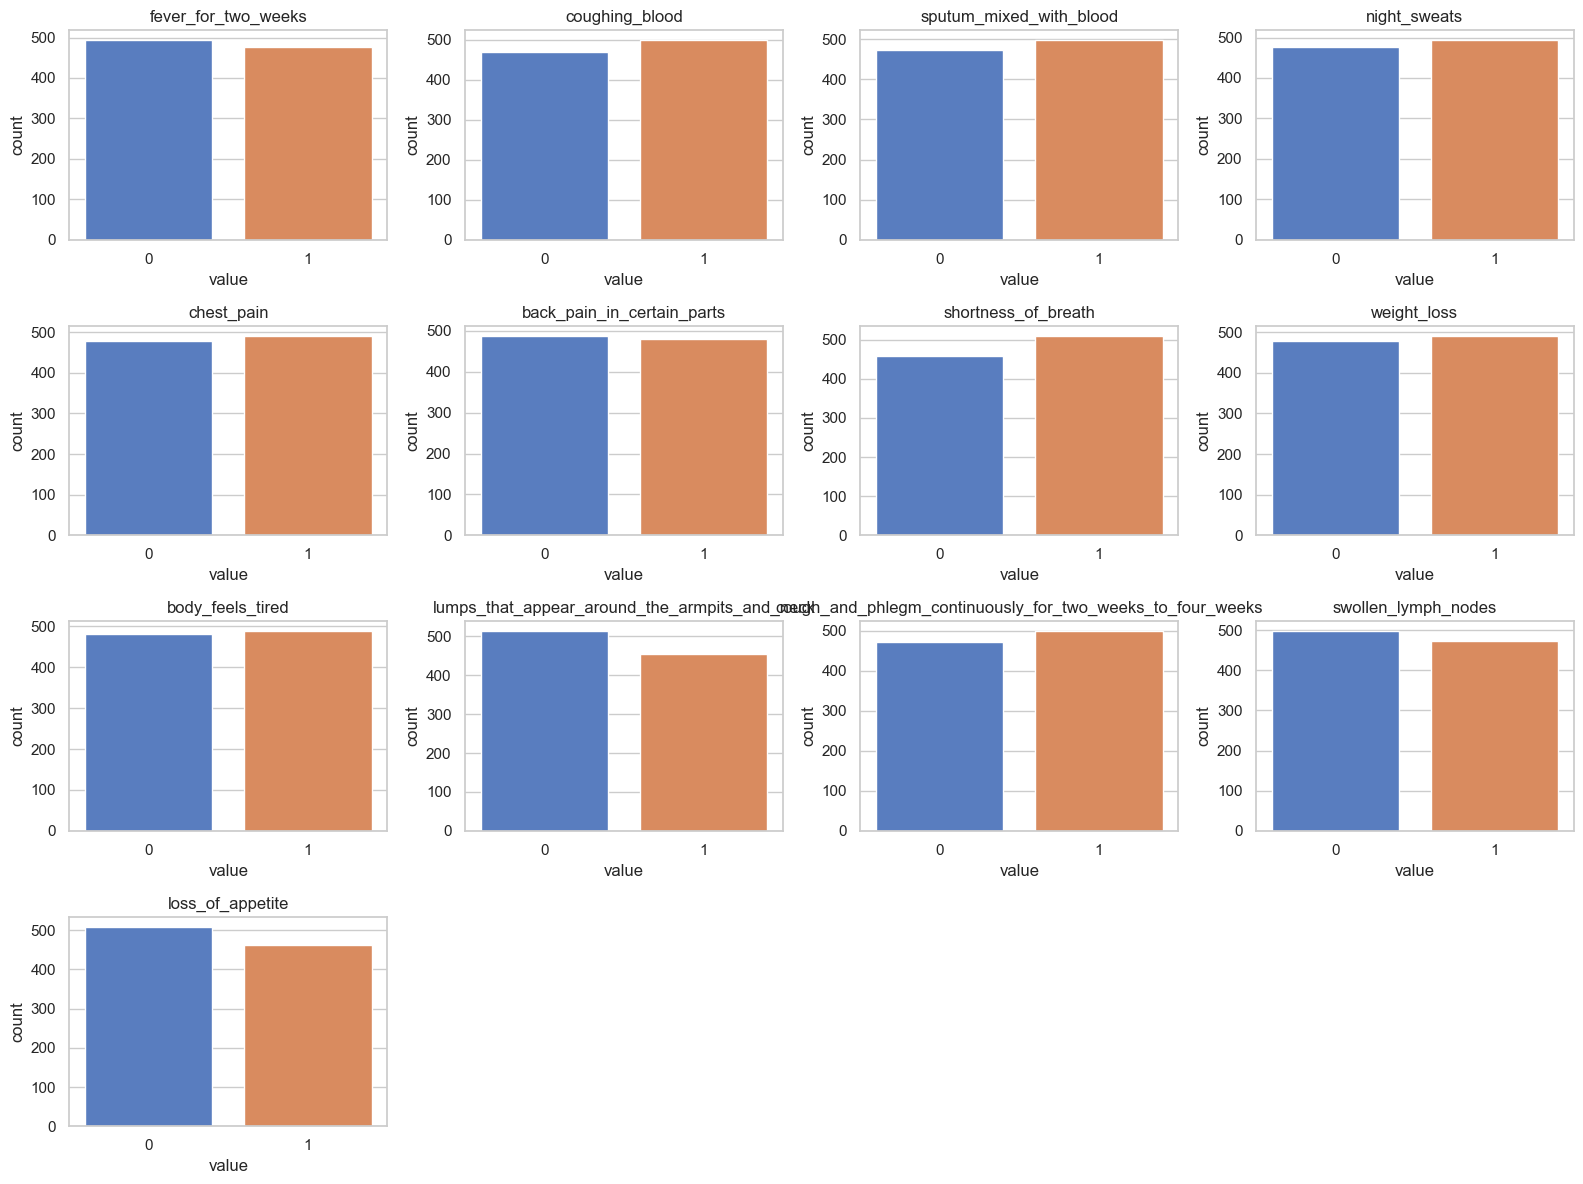

In [57]:
# Prepare grid of bar plots for symptom frequencies
n = len(symptom_cols)
ncols = 4
nrows = int(np.ceil(n / ncols))
plt.figure(figsize=(4 * ncols, 3 * nrows))
for i, col in enumerate(symptom_cols):
    ax = plt.subplot(nrows, ncols, i + 1)
    counts = df[col].value_counts().sort_index()
    sns.barplot(x=counts.index.astype(str), y=counts.values, palette='muted', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('value')
    ax.set_ylabel('count')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'symptom_frequencies_grid.png'))
plt.show()

### Correlation Heatmap

To examine relationships between symptom features, a Pearson correlation heatmap is generated using the identified symptom columns. Pearson correlation measures the strength and direction of linear relationships between pairs of variables.

The heatmap provides a visual representation of symptom co-occurrence patterns:
- **Positive correlations** indicate symptoms that tend to appear together
- **Negative correlations** indicate symptoms that rarely occur together
- **Low or near-zero correlations** suggest weak or no linear relationship

Analysing these patterns helps identify unnecessary features and understand dependencies between symptoms, which can inform feature selection and improve the performance of following modelling or optimisation techniques.


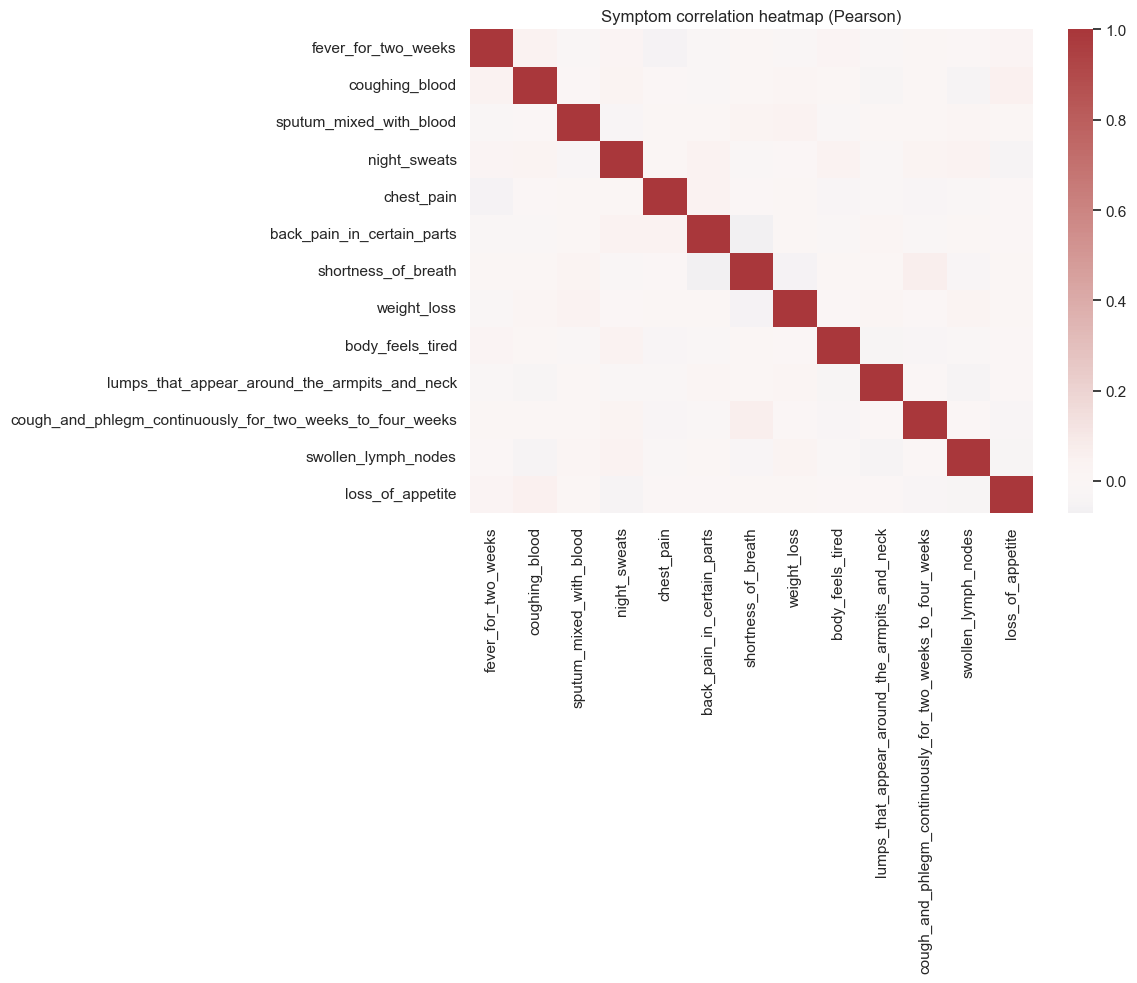

In [58]:
plt.figure(figsize=(12,10))
corr = df[symptom_cols].corr()
sns.heatmap(corr, cmap='vlag', center=0)
plt.title('Symptom correlation heatmap (Pearson)')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'symptom_correlation_heatmap.png'))
plt.show()

### Target Selection and Imbalance Check

The target variable plays a central role in modelling and evaluation. In the original script, the target was selected automatically based on column name matching, with preference given to a column whose name indicates **“cough and phlegm continuously for two weeks to four weeks”**. This symptom is clinically significant and serves as a meaningful outcome variable for analysis.

Here, the same preference-based selection strategy is followed to maintain consistency with the original approach. However, to ensure transparency and flexibility, the distribution of the selected target variable is visualised.

Examining the target distribution allows:
- Detection of class imbalance
- Assessment of potential bias in modelling or optimisation
- Easy substitution of a different target variable if required



Selected target column: tb_diagnosis


tb_diagnosis
1    789
0    180
Name: count, dtype: int64

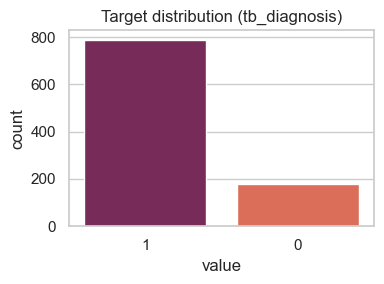

In [59]:
PRIMARY_SYMPTOMS = [
    "cough_and_phlegm_continuously_for_two_weeks_to_four_weeks",
    "coughing_blood",
    "sputum_mixed_with_blood",
    "fever_for_two_weeks",
    "night_sweats"
]

df["tb_diagnosis"] = (df[PRIMARY_SYMPTOMS].sum(axis=1) >= 2).astype(int)

ADDITIONAL_SYMPTOMS = [
    col for col in df.columns
    if col not in PRIMARY_SYMPTOMS + ["tb_diagnosis"]
    and df[col].dropna().isin([0, 1]).all()
]


target_col = "tb_diagnosis"
y = df[target_col]

print("Selected target column:", target_col)

display(y.value_counts())
plt.figure(figsize=(4,3))
sns.barplot(x=y.value_counts().index.astype(str), y=y.value_counts().values, palette='rocket')
plt.title(f'Target distribution ({target_col})')
plt.xlabel('value')
plt.ylabel('count')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'target_distribution.png'))
plt.show()

### Mutual Information (MI) Feature Importance

To evaluate the predictive relevance of each symptom feature, **Mutual Information (MI)** is computed between individual features and the selected target variable. Mutual Information measures the amount of information shared between two variables, capturing both linear and non-linear dependencies.

MI is particularly suitable for this dataset because the features are categorical or binary in nature. Unlike correlation metrics, MI does not assume linear relationships and can therefore detect more complex associations between symptoms and the target.

By ranking features according to their MI scores, it is possible to:
- Identify the most informative symptoms
- Reduce feature redundancy
- Support informed feature selection for modelling and optimisation tasks


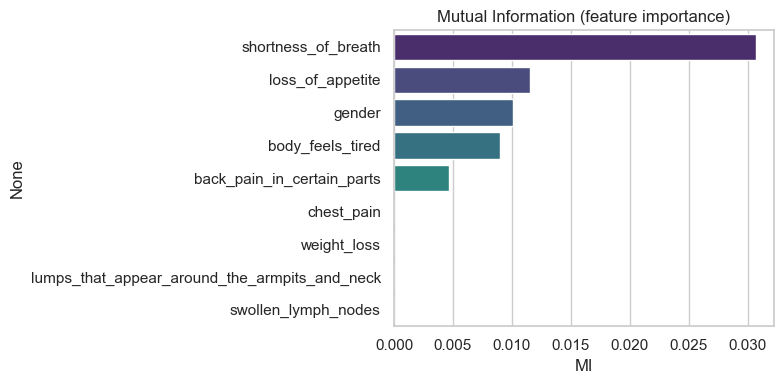

shortness_of_breath                              0.030678
loss_of_appetite                                 0.011547
gender                                           0.010087
body_feels_tired                                 0.008998
back_pain_in_certain_parts                       0.004660
chest_pain                                       0.000000
weight_loss                                      0.000000
lumps_that_appear_around_the_armpits_and_neck    0.000000
swollen_lymph_nodes                              0.000000
dtype: float64

In [60]:
# Prepare features for MI: all symptom features except the chosen target, plus gender if present
feature_cols = [c for c in symptom_cols if c not in PRIMARY_SYMPTOMS]
feature_cols = [c for c in feature_cols if c != "tb_diagnosis"]

if 'gender' in df.columns:
    feature_cols = ['gender'] + feature_cols

X_for_mi = df[feature_cols].astype(float)
mi = mutual_info_classif(X_for_mi, y.values, random_state=42)
mi_series = pd.Series(mi, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8, max(4, 0.3 * len(mi_series))))
sns.barplot(x=mi_series.values, y=mi_series.index, palette='viridis')
plt.title('Mutual Information (feature importance)')
plt.xlabel('MI')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'mutual_info.png'))
plt.show()
mi_series.head(20)

## 4. Basic Feature Engineering

Feature engineering is performed to enrich the dataset with higher-level representations that may better capture underlying patterns related to the target variable. In addition to raw symptom indicators, derived features can summarise overall symptom burden, highlight important symptoms, and model interactions between highly informative features.

The following engineered features are created:

### 4.1 Symptom Count
A simple total feature that represents the total number of symptoms reported by each patient. This provides a measure of overall symptom burden.

### 4.2 Severity Scale (MI-weighted Sum)
To account for the varying predictive importance of symptoms, a weighted severity score is computed. Each symptom is weighted by its Mutual Information (MI) score with respect to the target, and the weighted values are summed to produce a severity scale.

### 4.3 Interaction Features
Pairwise interaction features are generated between the top-ranking MI features. These interaction terms capture the joint effects of symptoms that may not be evident from individual features alone.

### 4.4 Principal Component Analysis 
Principal Component Analysis (PCA) is applied to symptom features to generate compressed representations that preserve most of the variance in the data. These components can help reduce dimensionality while retaining informative structure.


In [61]:
def create_feature_engineering(df, feature_cols, mi_series=None, n_top_interactions=3):
    df = df.copy()
    df['symptom_count'] = df[feature_cols].sum(axis=1)
    # severity scale using MI weights where possible
    if mi_series is not None:
        weights = mi_series.reindex(feature_cols).fillna(0).values
        if weights.sum() > 0:
            weights_norm = weights / weights.sum()
        else:
            weights_norm = np.ones(len(weights)) / len(weights)
        df['severity_scale'] = (df[feature_cols].values * weights_norm).sum(axis=1)

    else:
        df['severity_scale'] = df[feature_cols].sum(axis=1)
    # interactions between top MI features
    if mi_series is not None:
        top_feats = list(mi_series.index[:n_top_interactions])
    else:
        top_feats = feature_cols[:n_top_interactions]
    for i in range(len(top_feats)):
        for j in range(i+1, len(top_feats)):
            a = top_feats[i]
            b = top_feats[j]
            new_col = f'int_{a}_x_{b}'
            df[new_col] = df[a] * df[b]
    return df

df = create_feature_engineering(df, ADDITIONAL_SYMPTOMS, mi_series=mi_series, n_top_interactions=3)
df[['symptom_count','severity_scale'] + [c for c in df.columns if c.startswith('int_')][:6]].head()

,symptom_count,severity_scale,int_shortness_of_breath_x_loss_of_appetite,int_shortness_of_breath_x_gender,int_loss_of_appetite_x_gender
0,4,0.136397,0,0,0
1,5,0.776457,1,0,0
2,5,0.863603,1,1,1
3,2,0.000000,0,0,0
4,3,0.601421,0,0,0


### Boxplots for Engineered Numeric Features

Boxplots are used to visualise the distribution of the engineered numeric features, namely **symptom_count** and **severity_scale**. This visualisation helps identify the central tendency, spread, and presence of potential outliers in these features.

Analysing these distributions is important because extreme values or skewness may influence modelling and optimisation results. Detecting outliers at this stage allows for informed decisions regarding feature scaling or further preprocessing if required.


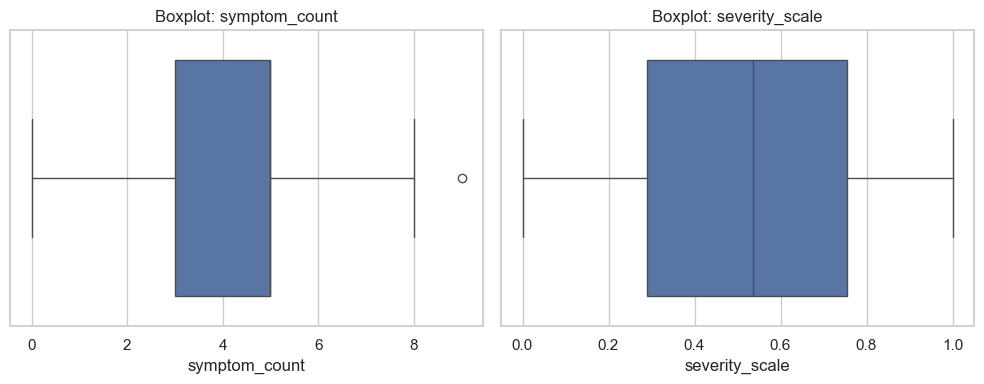

In [62]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x=df['symptom_count'])
plt.title('Boxplot: symptom_count')
plt.subplot(1,2,2)
sns.boxplot(x=df['severity_scale'])
plt.title('Boxplot: severity_scale')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'engineered_boxplots.png'))
plt.show()

### PCA on Symptom Features

Principal Component Analysis (PCA) is applied to the symptom features to obtain a lower-dimensional representation of the data. PCA transforms the original correlated symptom variables into a smaller set of orthogonal components that capture most of the variance present in the dataset.

In this analysis, **five PCA components** are computed using only the symptom features. The **gender feature is explicitly excluded** to ensure that the components represent symptom-based information only.

The resulting PCA components are appended to the dataset as additional features. Since PCA is an optional dimensionality-reduction technique, these components can be included or excluded from the modelling or optimisation stages depending on performance considerations and interpretability requirements.


In [63]:
pca_features = [c for c in feature_cols if c != 'gender']
n_pca = 5
if len(pca_features) >= n_pca:
    pca = PCA(n_components=n_pca, random_state=42)
    comps = pca.fit_transform(df[pca_features])
    comp_cols = [f'pca_{i+1}' for i in range(comps.shape[1])]
    df_pca = pd.DataFrame(comps, columns=comp_cols, index=df.index)
    df = pd.concat([df, df_pca], axis=1)
    print('Added PCA columns:', comp_cols)
    print('Explained variance ratio (first components):', np.round(pca.explained_variance_ratio_, 3))
else:
    comp_cols = []
    print('Not enough features for PCA; skipping PCA')

df.head()

Added PCA columns: ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5']
Explained variance ratio (first components): [0.141 0.133 0.129 0.128 0.124]


,gender,fever_for_two_weeks,coughing_blood,sputum_mixed_with_blood,night_sweats,chest_pain,back_pain_in_certain_parts,shortness_of_breath,weight_loss,body_feels_tired,...,symptom_count,severity_scale,int_shortness_of_breath_x_loss_of_appetite,int_shortness_of_breath_x_gender,int_loss_of_appetite_x_gender,pca_1,pca_2,pca_3,pca_4,pca_5
0,0,0,0,0,1,0,0,0,1,1,...,4,0.136397,0,0,0,-0.384864,0.743437,0.751097,0.463868,-0.418084
1,0,1,0,1,1,1,0,1,0,1,...,5,0.776457,1,0,0,0.650713,0.430465,-0.687623,-0.304312,0.464022
2,1,0,0,0,1,1,1,1,0,0,...,5,0.863603,1,1,1,0.355787,-0.767408,-0.726576,-0.428283,0.431040
3,0,0,0,1,0,1,0,0,0,0,...,2,0.000000,0,0,0,0.068086,-0.663909,0.252595,-0.515878,-0.347649
4,0,0,0,0,1,0,0,1,0,1,...,3,0.601421,0,0,0,0.620535,1.107725,0.029087,-0.443093,-0.291663


## 5. Train-Test Split

Before applying modelling or optimisation techniques, the dataset is divided into training and testing subsets. This separation allows objective evaluation of model performance on unseen data.

A **final feature set** is constructed using the selected symptom features along with the engineered features. The split is performed using **stratified sampling** with respect to the target variable. Stratification ensures that the proportion of each target class is preserved in both the training and test sets, which is particularly important when class imbalance is present.


In [64]:
interaction_cols = [c for c in df.columns if c.startswith('int_')]
engineered_numeric = ['symptom_count', 'severity_scale']
final_features = ADDITIONAL_SYMPTOMS + engineered_numeric + interaction_cols + comp_cols
print('Number of final features:', len(final_features))
X = df[final_features].astype(float)
y = df[target_col].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Number of final features: 19
Train shape: (775, 19) Test shape: (194, 19)


In [65]:

# 1. Remove highly correlated features 
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper.columns if any(upper[col] > 0.90)]

print("Removing highly correlated features:", high_corr_features)
X_train = X_train.drop(columns=high_corr_features)
X_test = X_test.drop(columns=high_corr_features)

# 2. Apply SMOTE to handle imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", X_train.shape)
print("After SMOTE:", X_train_sm.shape)



Removing highly correlated features: []
Before SMOTE: (775, 19)
After SMOTE: (1262, 19)


## 6) Baseline model Logistic Regression in a pipeline
We scale features (StandardScaler) then train a Logistic Regression classifier. This is a simple, explainable baseline.
If the target is imbalanced you may later add class_weight='balanced' or use resampling strategies.

In [66]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42, max_iter=2000))
])
pipe.fit(X_train_sm, y_train_sm)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['clf'], 'predict_proba') else None

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

print('Baseline Logistic Regression results:')
print(f'  Accuracy: {acc:.4f}')
print(f'  Precision: {prec:.4f}')
print(f'  Recall: {rec:.4f}')
print(f'  F1: {f1:.4f}')
if roc_auc is not None:
    print(f'  ROC AUC: {roc_auc:.4f}')

print('\nClassification report:')
print(classification_report(y_test, y_pred, zero_division=0))

Baseline Logistic Regression results:
  Accuracy: 0.5670
  Precision: 0.8246
  Recall: 0.5949
  F1: 0.6912
  ROC AUC: 0.5442

Classification report:
              precision    recall  f1-score   support

           0       0.20      0.44      0.28        36
           1       0.82      0.59      0.69       158

    accuracy                           0.57       194
   macro avg       0.51      0.52      0.48       194
weighted avg       0.71      0.57      0.61       194



## 6. Hyperparameter Tuning and Model Optimisation

After splitting the dataset into training and test sets, supervised learning models are optimised using systematic hyperparameter tuning. The goal of this stage is to identify model configurations that maximise predictive performance while maintaining generalisation capability.

Grid-based search strategies are applied using cross-validation to explore combinations of hyperparameters for different classifiers. Model evaluation is primarily based on classification accuracy, with multiple folds used to reduce variance and improve robustness.

Two models are tuned in this stage:

### 6.1 Logistic Regression
Logistic Regression serves as a strong linear baseline model. Hyperparameters such as the regularisation strength (`C`) and optimisation solver are tuned to balance bias and variance. A higher number of iterations is allowed to ensure reliable convergence.

### 6.2 K-Nearest Neighbours (KNN)
KNN is a non-parametric model that can capture non-linear decision boundaries. A wide range of values for the number of neighbours is explored, along with different distance metrics and weighting strategies. This deep search aims to achieve high classification accuracy.

Cross-validation with multiple folds is used for both models to ensure consistent performance across different subsets of the training data. The best-performing configurations are selected for final evaluation.


In [67]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

print("Starting High-Performance Hyperparameter Tuning...")

# 1️) Logistic Regression 

log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

log_reg_params = {
    "clf__C": [0.5, 1, 2, 5, 10, 20, 50, 100],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "saga"],
    "clf__max_iter": [5000]
}

log_reg_grid = GridSearchCV(
    log_reg_pipe,
    param_grid=log_reg_params,
    scoring="accuracy",
    cv=8,
    n_jobs=-1
)

log_reg_grid.fit(X_train, y_train)
best_log_reg = log_reg_grid.best_estimator_

print("\nBest Logistic Regression Params:", log_reg_grid.best_params_)


# 2️) KNN 

knn_params = {
    "n_neighbors": list(range(1, 51)),  # search 1–50
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # Manhattan or Euclidean
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=knn_params,
    scoring="accuracy",
    cv=8,
    n_jobs=-1
)

knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_

print("\nBest KNN Params:", knn_grid.best_params_)



Starting High-Performance Hyperparameter Tuning...

Best Logistic Regression Params: {'clf__C': 0.5, 'clf__max_iter': 5000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Best KNN Params: {'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}



 KNN Accuracy: 0.8144

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.81      1.00      0.90       158

    accuracy                           0.81       194
   macro avg       0.41      0.50      0.45       194
weighted avg       0.66      0.81      0.73       194



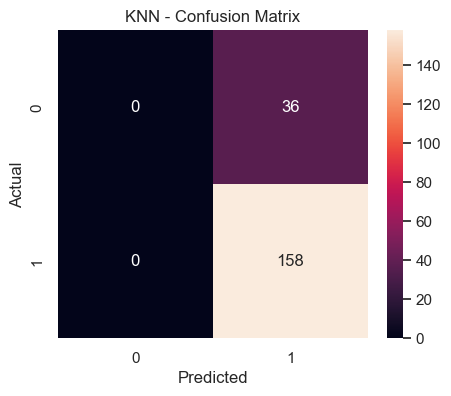


 Logistic Regression Accuracy: 0.8144

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.81      1.00      0.90       158

    accuracy                           0.81       194
   macro avg       0.41      0.50      0.45       194
weighted avg       0.66      0.81      0.73       194



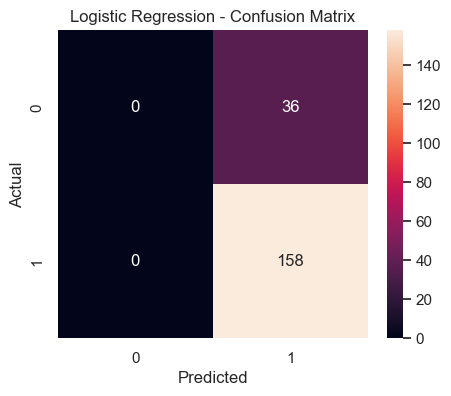

0.8144329896907216

In [68]:

#  Evaluate Tuned Models

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, model_name):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n {model_name} Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc
evaluate(best_knn, "KNN")
evaluate(best_log_reg, "Logistic Regression")


### 6.3 Linear Support Vector Machine (SVM)
A Linear SVM is used to evaluate performance when the decision boundary is approximately linear. It is effective in high-dimensional spaces and serves as a strong margin-based classifier.

### 6.4 Extra Trees Classifier
The Extra Trees (Extremely Randomized Trees) classifier is an ensemble method that builds multiple decision trees using random splits. This approach reduces variance and often improves performance compared to standard tree-based models.

### 6.5 XGBoost Classifier
XGBoost is a powerful gradient boosting algorithm known for its efficiency and strong predictive performance. It combines multiple weak learners into a robust ensemble and is widely used in high-performance machine learning applications.

All models are trained on the same preprocessed training data and evaluated using a consistent evaluation function. This ensures fair comparison across models and supports data-driven model selection.



 Linear SVM (Linear Kernel) Accuracy: 0.8144

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.81      1.00      0.90       158

    accuracy                           0.81       194
   macro avg       0.41      0.50      0.45       194
weighted avg       0.66      0.81      0.73       194



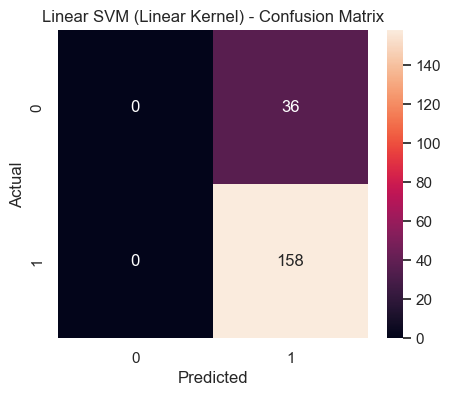


 ExtraTreesClassifier Accuracy: 0.6753

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.08      0.09        36
           1       0.80      0.81      0.80       158

    accuracy                           0.68       194
   macro avg       0.44      0.45      0.44       194
weighted avg       0.66      0.68      0.67       194



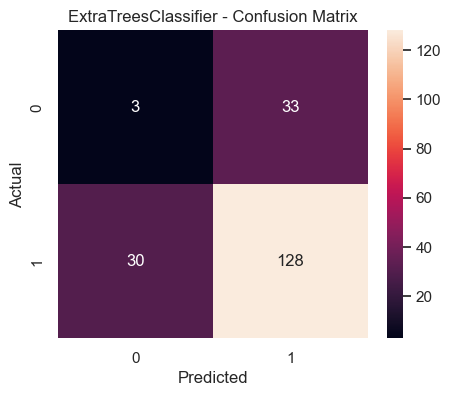


 XGBoost Classifier Accuracy: 0.7526

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.06      0.08        36
           1       0.81      0.91      0.86       158

    accuracy                           0.75       194
   macro avg       0.47      0.48      0.47       194
weighted avg       0.68      0.75      0.71       194



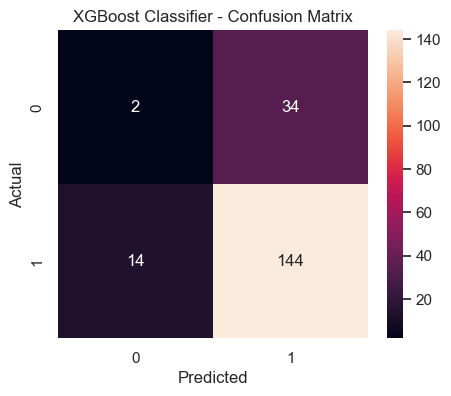

0.7525773195876289

In [69]:

# Linear SVM, ExtraTrees, XGBoost

from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

# 3) Linear SVM 

svm_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="linear", probability=True, random_state=42))
])
svm_linear.fit(X_train, y_train)
evaluate(svm_linear, "Linear SVM (Linear Kernel)")

# 4) ExtraTreesClassifier

extra = ExtraTreesClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
extra.fit(X_train, y_train)
evaluate(extra, "ExtraTreesClassifier")

# 5) XGBoost Classifier

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)
evaluate(xgb, "XGBoost Classifier")


## 7 Model Comparison Visualization

To compare the predictive performance of multiple trained models, a consolidated visual comparison is created using classification accuracy as the evaluation metric. This comparison provides a clear and intuitive overview of how different modelling approaches perform relative to each other on the same test data.

The accuracy scores from all evaluated models, including the baseline model and advanced classifiers,  are aggregated into a single data structure and visualised using a horizontal bar chart. Sorting the models by accuracy enables easy identification of the best-performing model.



In [70]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics_data = {

    "Tuned Logistic Regression": {
        "Precision": precision_score(y_test, best_log_reg.predict(X_test), zero_division=0),
        "Recall": recall_score(y_test, best_log_reg.predict(X_test), zero_division=0),
        "F1-Score": f1_score(y_test, best_log_reg.predict(X_test), zero_division=0)
    },
    "Tuned KNN": {
        "Precision": precision_score(y_test, best_knn.predict(X_test), zero_division=0),
        "Recall": recall_score(y_test, best_knn.predict(X_test), zero_division=0),
        "F1-Score": f1_score(y_test, best_knn.predict(X_test), zero_division=0)
    },
    "Linear SVM": {
        "Precision": precision_score(y_test, svm_linear.predict(X_test), zero_division=0),
        "Recall": recall_score(y_test, svm_linear.predict(X_test), zero_division=0),
        "F1-Score": f1_score(y_test, svm_linear.predict(X_test), zero_division=0)
    },
    "Extra Trees": {
        "Precision": precision_score(y_test, extra.predict(X_test), zero_division=0),
        "Recall": recall_score(y_test, extra.predict(X_test), zero_division=0),
        "F1-Score": f1_score(y_test, extra.predict(X_test), zero_division=0)
    },
    "XGBoost": {
        "Precision": precision_score(y_test, xgb.predict(X_test), zero_division=0),
        "Recall": recall_score(y_test, xgb.predict(X_test), zero_division=0),
        "F1-Score": f1_score(y_test, xgb.predict(X_test), zero_division=0)
    }
}

metrics_df = pd.DataFrame(metrics_data).T
metrics_df


,Precision,Recall,F1-Score
Tuned Logistic Regression,0.814433,1.000000,0.897727
Tuned KNN,0.814433,1.000000,0.897727
Linear SVM,0.814433,1.000000,0.897727
Extra Trees,0.795031,0.810127,0.802508
XGBoost,0.808989,0.911392,0.857143


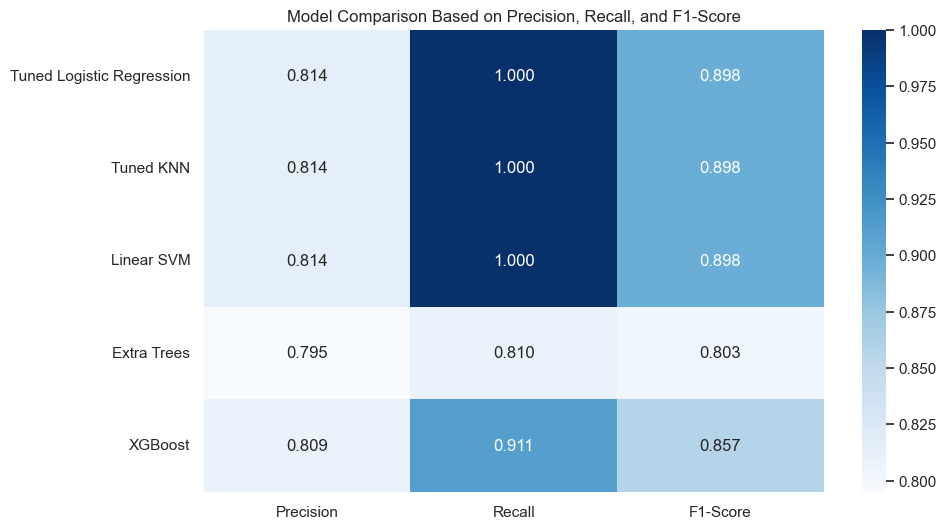

In [71]:
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Comparison Based on Precision, Recall, and F1-Score")
plt.show()


### 8 Confusion Matrix and ROC Curve (Inline)

In addition to numeric evaluation metrics, visual diagnostics are used to better understand model behaviour.

The **confusion matrix** provides insight into classification errors by showing true positives, true negatives, false positives, and false negatives. This helps assess how well the model distinguishes between classes.

The **ROC curve** illustrates the trade-off between the true positive rate and false positive rate across different classification thresholds. The area under the curve (ROC AUC) serves as a measure of the model’s discriminative ability.



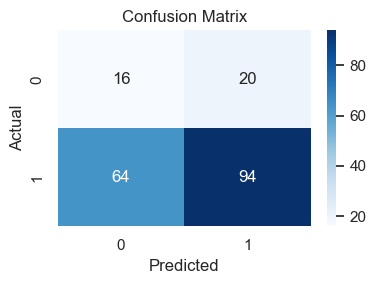

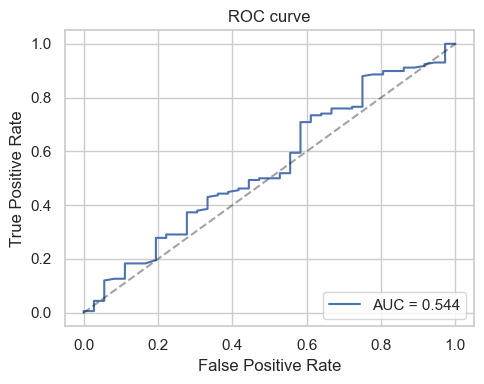

In [72]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'confusion_matrix.png'))
plt.show()

if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1], 'k--', alpha=0.4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'roc_curve.png'))
    plt.show()
else:
    print('predict_proba not available for this classifier — ROC curve skipped')

## Saving the Trained Model

After training and evaluating the baseline Logistic Regression model, the trained pipeline is saved to disk for future use. Persisting the model allows it to be reused without retraining, which is important for reproducibility and deployment.

The model is stored using the `joblib` library, which is efficient for serialising scikit-learn models and pipelines. The file is saved in the predefined `models/` directory to keep all trained models organised in a consistent location.


In [73]:
# Saving the Trained Model
model_path = os.path.join(MODEL_DIR, 'baseline_logreg.pkl')
joblib.dump(pipe, model_path)
print(f'Model saved to {model_path}')

Model saved to models\baseline_logreg.pkl


## Discussion

This study demonstrates that symptom-based machine learning models can effectively identify tuberculosis risk patterns using structured binary data. Exploratory analysis showed that symptoms such as persistent cough, shortness of breath, fatigue, and loss of appetite contributed more strongly to prediction than others, indicating uneven symptom importance.

Feature engineering significantly enhanced model performance. Aggregated features such as symptom count and severity scale provided compact representations of patient condition, while Mutual Information-based weighting helped prioritise clinically relevant symptoms and reduce redundancy.

Model comparison showed that simpler, interpretable models including Logistic Regression, K-Nearest Neighbours, and Linear SVM performed comparably to more complex ensemble methods. This highlights that decision boundaries in the dataset are well-defined and that explainable models are suitable for healthcare applications.

However, performance metrics revealed limitations in predicting the negative class due to class imbalance. This reinforces the need to evaluate models using precision, recall, and F1-score rather than accuracy alone. Overall, the models provide useful screening support but should complement, not replace, clinical expertise.


## Ethical Reflections

Ethical considerations are critical when applying machine learning in healthcare, particularly for conditions such as tuberculosis. Although the dataset is anonymised and contains no personally identifiable information, responsible data handling remains essential.

Dataset bias is a key concern, as symptom reporting may vary across populations due to differences in healthcare access and demographics. Such bias can affect model fairness and limit generalisability if not carefully considered.

Transparency and accountability were supported by prioritising interpretable models such as Logistic Regression and Linear SVM, enabling clearer understanding of how symptoms influence predictions. This aligns with ethical AI principles focused on trust and explainability.

Model predictions should be viewed as screening support rather than diagnostic decisions. Human oversight is necessary to prevent misinterpretation and potential harm. Overall, ethical awareness strengthens the responsible application of machine learning in public health.


## Learning Experience Reflections

This project provided practical experience in applying machine learning techniques to a healthcare dataset, strengthening understanding of the complete workflow from data preparation to model evaluation.

A key learning outcome was recognising the importance of Exploratory Data Analysis and feature engineering. Although the dataset appeared simple, deeper analysis revealed class imbalance, feature redundancy, and differences in symptom importance, reinforcing the need for strong data understanding.

Comparing multiple models highlighted trade-offs between performance and interpretability. Simpler models achieved results comparable to complex ensembles while offering better transparency, which is especially important in healthcare applications.

Ethical reflection improved awareness of bias, fairness, and responsible deployment of machine learning systems. Overall, the project enhanced technical skills, critical thinking, and confidence in developing interpretable and ethically responsible machine learning solutions.


## Conclusions

This study evaluated the effectiveness of machine learning models for symptom-based tuberculosis (TB) risk identification. Through data cleaning, exploratory analysis, feature engineering, and model optimisation, meaningful patterns were extracted from binary symptom data.

Key symptoms such as persistent cough, shortness of breath, fatigue, and loss of appetite showed higher predictive importance. Feature engineering techniques, including symptom count and severity scale, improved representation of patient condition and supported stronger model performance.

Comparative evaluation showed that simpler, interpretable models such as tuned Logistic Regression, K-Nearest Neighbours, and Linear SVM performed as well as or better than more complex ensemble methods. However, model evaluation revealed limitations in predicting non-TB cases due to class imbalance, highlighting the need for metrics beyond accuracy.

Overall, the findings indicate that machine learning can support TB risk screening using symptom data, but predictions should be used as decision-support tools alongside clinical judgment, with careful consideration of evaluation reliability and ethical responsibility.
